In [ ]:
!pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 59.3 MB/s 


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyupbit
from pyupbit.quotation_api import get_tickers
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop, Nadam, Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from IPython.display import SVG
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model


In [ ]:
#데이터 불러오기

df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",1581, to = '20220501')
df_ETH = df_ETH.drop("value",axis=1)
print(df_ETH)


df_BTC = pyupbit.get_ohlcv("KRW-BTC","hour",1581, to = '20220501')
df_BTC= df_BTC.drop("value",axis=1)
print(df_BTC)


df_ETC = pyupbit.get_ohlcv("KRW-ETC","hour",1581, to = '20220501')
df_ETC = df_ETC.drop("value",axis=1)
print(df_ETC)

df_XRP = pyupbit.get_ohlcv("KRW-XRP","hour",1581, to = '20220501')
df_XRP = df_XRP.drop("value",axis=1)
print(df_XRP)

df_ADA = pyupbit.get_ohlcv("KRW-ADA","hour",1581, to = '20220501')
df_ADA = df_ADA.drop("value",axis=1)
print(df_ADA)

df_QTUM = pyupbit.get_ohlcv("KRW-QTUM","hour",1581, to = '20220501')
df_QTUM = df_QTUM.drop("value",axis=1)
print(df_QTUM)


                          open       high        low      close         volume
2018-01-01 09:00:00  1028000.0  1076000.0  1011500.0  1057000.0   51315.571156
2018-01-02 09:00:00  1056500.0  1270500.0  1051000.0  1177000.0  158481.289301
2018-01-03 09:00:00  1177000.0  1324500.0  1157500.0  1295500.0   83430.944304
2018-01-04 09:00:00  1295500.0  1518000.0  1269000.0  1439500.0   97018.955981
2018-01-05 09:00:00  1439500.0  1645000.0  1406500.0  1554500.0  109665.854669
...                        ...        ...        ...        ...            ...
2022-04-26 09:00:00  3766000.0  3799000.0  3553000.0  3596000.0   39317.760548
2022-04-27 09:00:00  3597000.0  3702000.0  3580000.0  3677000.0   24282.807473
2022-04-28 09:00:00  3677000.0  3786000.0  3646000.0  3737000.0   26791.875509
2022-04-29 09:00:00  3737000.0  3753000.0  3603000.0  3628000.0   26801.567048
2022-04-30 09:00:00  3630000.0  3656000.0  3564000.0  3570000.0   17625.435214

[1581 rows x 5 columns]
                           

In [ ]:
data = pd.read_csv('Data.csv')
data.set_index(df_ETH.index, inplace = True)

df_ETH = pd.concat([df_ETH, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,15,16,17]]], axis=1)
df_BTC = pd.concat([df_BTC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]], axis=1)
df_ETC = pd.concat([df_ETC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,18,19,20]]], axis=1)
df_XRP = pd.concat([df_XRP, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,27,28,29]]], axis=1)
df_ADA = pd.concat([df_ADA, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,21,22,23]]], axis=1)
df_QTUM = pd.concat([df_QTUM, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,24,25,26]]], axis=1)

In [ ]:
def split(x):
    y = pd.DataFrame(x)
    a = int(len(y)*0.8)
    y1 = y.iloc[:a,:].values
    y2 = y.iloc[a:,:].values
    return y1,y2                
            
ETH_train,ETH_test = split(df_ETH)
BTC_train,BTC_test = split(df_BTC)
ETC_train,ETC_test = split(df_ETC)
XRP_train,XRP_test = split(df_XRP)    
ADA_train,ADA_test = split(df_ADA)
QTUM_train,QTUM_test = split(df_QTUM)

sc_ETH = MinMaxScaler()
ETH_train = sc_ETH.fit_transform(ETH_train)
ETH_test = sc_ETH.transform(ETH_test)

sc_BTC = MinMaxScaler()
BTC_train = sc_BTC.fit_transform(BTC_train)
BTC_test = sc_BTC.transform(BTC_test)

sc_ETC = MinMaxScaler()
ETC_train = sc_ETC.fit_transform(ETC_train)
ETC_test = sc_ETC.transform(ETC_test)

sc_XRP = MinMaxScaler()
XRP_train = sc_XRP.fit_transform(XRP_train)
XRP_test = sc_XRP.transform(XRP_test)

sc_ADA = MinMaxScaler()
ADA_train = sc_ADA.fit_transform(ADA_train)
ADA_test = sc_ADA.transform(ADA_test)

sc_QTUM = MinMaxScaler()
QTUM_train = sc_QTUM.fit_transform(QTUM_train)
QTUM_test = sc_QTUM.transform(QTUM_test)
            
def inputsize(df_train,df_test):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for i in range(3,len(df_train)+1):
        x_train.append(df_train[i-3:i,:])
        y_train.append(df_train[i-1,3])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    for i in range(3,len(df_test)+1):
        x_test.append(df_test[i-3:i,:])
        y_test.append(df_test[i-1,3])
        
    x_test, y_test = np.array(x_test), np.array(y_test) 
    
    return x_train, y_train, x_test, y_test

ETH_x_train, ETH_y_train, ETH_x_test, ETH_y_test = inputsize(ETH_train,ETH_test)
BTC_x_train, BTC_y_train, BTC_x_test, BTC_y_test = inputsize(BTC_train,BTC_test)
ETC_x_train, ETC_y_train, ETC_x_test, ETC_y_test = inputsize(ETC_train,ETC_test)
XRP_x_train, XRP_y_train, XRP_x_test, XRP_y_test = inputsize(XRP_train,XRP_test)
ADA_x_train, ADA_y_train, ADA_x_test, ADA_y_test = inputsize(ADA_train,ADA_test)
QTUM_x_train, QTUM_y_train, QTUM_x_test, QTUM_y_test = inputsize(QTUM_train,QTUM_test)


In [ ]:
# 가중치 초기화
initializer = keras.initializers.glorot_normal(seed = 21)

In [ ]:
# 이더리움 학습
ETH_model = Sequential() 

ETH_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

ETH_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

ETH_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

ETH_model.add(Dense(units = 1))

ETH_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
ETH_model.fit(ETH_x_train,ETH_y_train, epochs = 200, batch_size = 32, verbose = 0)
ETH_prediction = ETH_model.predict(ETH_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


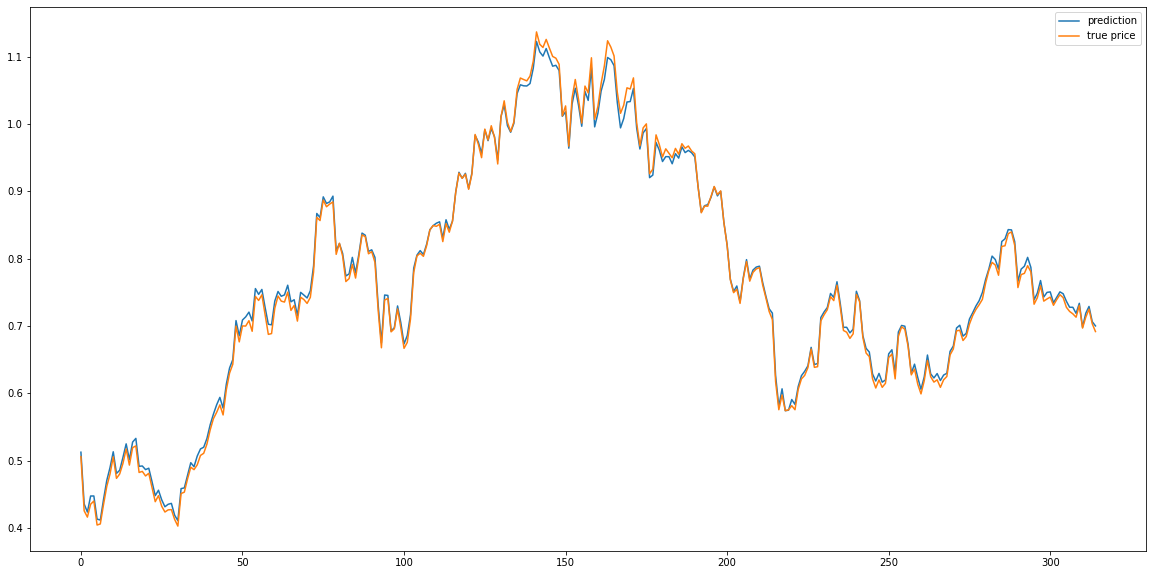

6.280089710030882e-05


In [ ]:
# 이더리움 시각화

x1 = []
for i in range(ETH_prediction.shape[0]):
    x1.append(i)
    
plt.figure(figsize = (20,10))    
plt.plot(x1,ETH_prediction,label = 'prediction')
plt.plot(x1, ETH_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE
ETH_MSE = mean_squared_error(ETH_prediction,ETH_y_test)
print(ETH_MSE)

In [ ]:
# 비트코인 학습
BTC_model = Sequential() 

BTC_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

BTC_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

BTC_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

BTC_model.add(Dense(units = 1))

BTC_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
BTC_model.fit(BTC_x_train,BTC_y_train, epochs = 200, batch_size = 32, verbose = 0)
BTC_prediction = BTC_model.predict(BTC_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


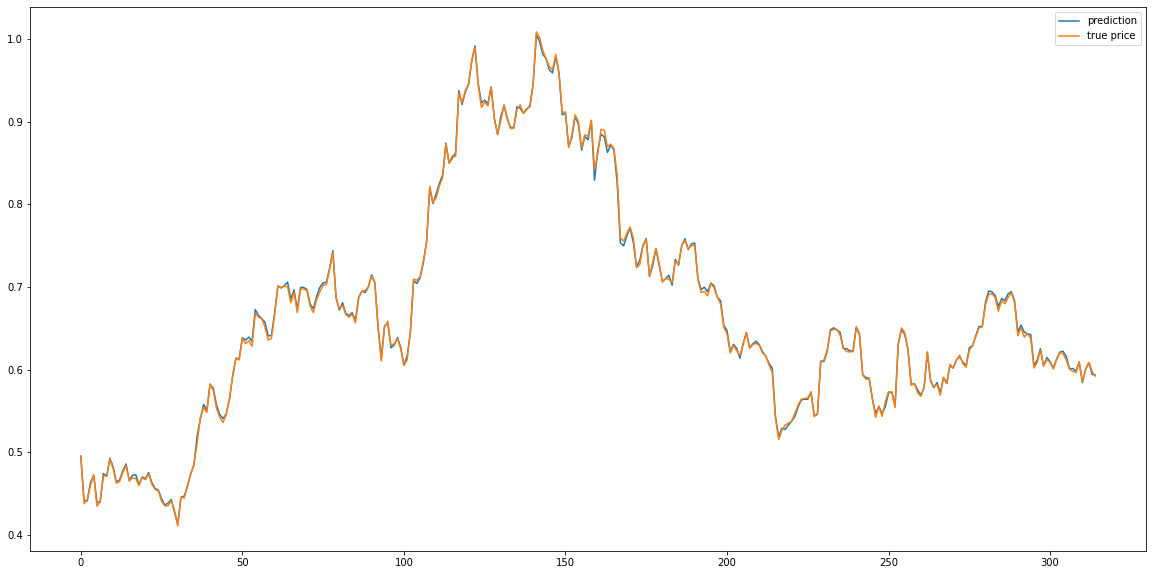

8.346895120026665e-06


In [ ]:
# 비트코인 시각화

x1 = []
for i in range(BTC_prediction.shape[0]):
    x1.append(i)

plt.figure(figsize = (20,10))    
plt.plot(x1,BTC_prediction,label = 'prediction')
plt.plot(x1, BTC_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE

BTC_MSE = mean_squared_error(BTC_prediction,BTC_y_test)
print(BTC_MSE)

In [ ]:
# 이더리움 클래식 학습
ETC_model = Sequential() 

ETC_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

ETC_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

ETC_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

ETC_model.add(Dense(units = 1))

ETC_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
ETC_model.fit(ETC_x_train,ETC_y_train, epochs = 200, batch_size = 32, verbose = 0)
ETC_prediction = ETC_model.predict(ETC_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


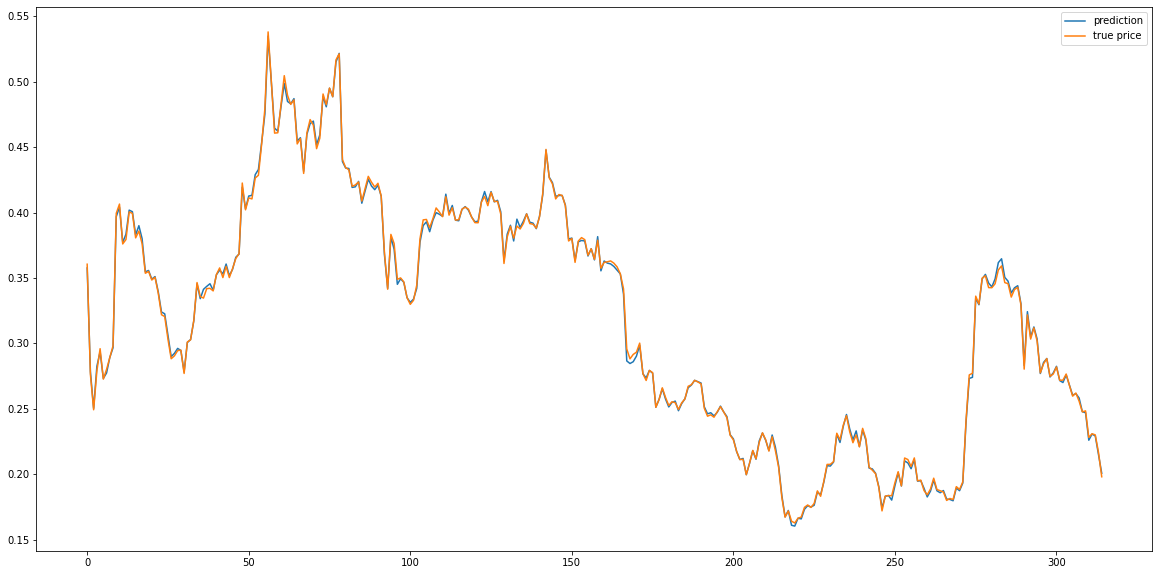

3.8534233613233105e-06


In [ ]:
# 이더리움 클래식 시각화
x1 = []
for i in range(ETC_prediction.shape[0]):
    x1.append(i)

plt.figure(figsize = (20,10))   
plt.plot(x1,ETC_prediction,label = 'prediction')
plt.plot(x1, ETC_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE

ETC_MSE = mean_squared_error(ETC_prediction,ETC_y_test)
print(ETC_MSE)

In [ ]:
# 리플 학습
XRP_model = Sequential() 

XRP_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

XRP_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

XRP_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

XRP_model.add(Dense(units = 1))

XRP_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
XRP_model.fit(XRP_x_train,XRP_y_train, epochs = 200, batch_size = 32, verbose = 0)
XRP_prediction = XRP_model.predict(XRP_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


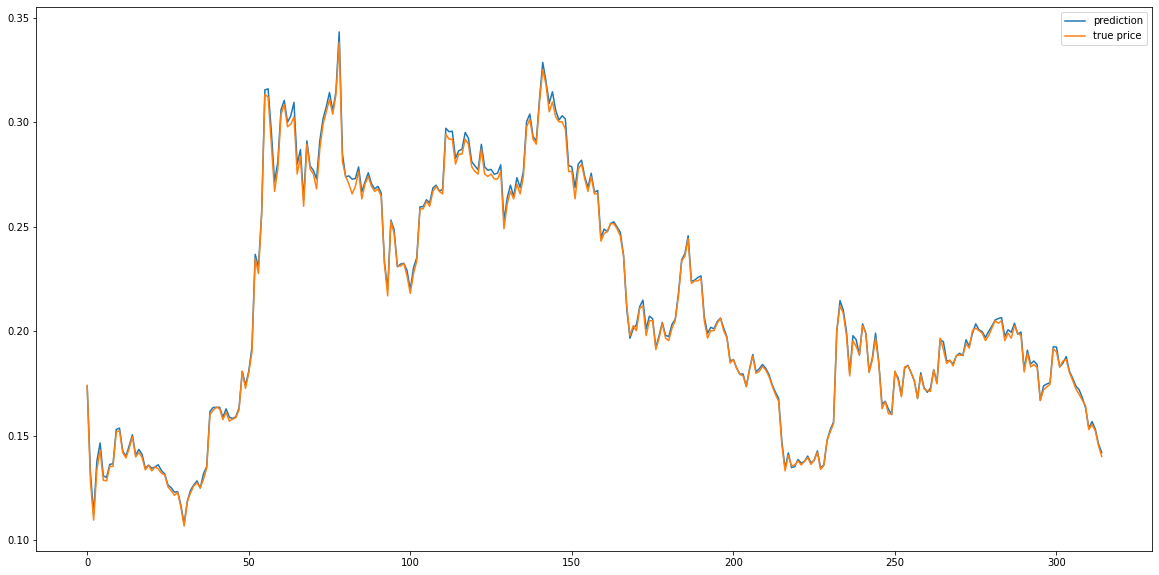

3.991522758765885e-06


In [ ]:
# 리플 시각화
x1 = []
for i in range(XRP_prediction.shape[0]):
    x1.append(i)

plt.figure(figsize = (20,10)) 
plt.plot(x1,XRP_prediction,label = 'prediction')
plt.plot(x1, XRP_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE

XRP_MSE = mean_squared_error(XRP_prediction,XRP_y_test)
print(XRP_MSE)

In [ ]:
# 아다 학습
ADA_model = Sequential() 

ADA_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

ADA_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

ADA_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

ADA_model.add(Dense(units = 1))

ADA_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
ADA_model.fit(ADA_x_train,ADA_y_train, epochs = 200, batch_size = 32, verbose = 0)
ADA_prediction = ADA_model.predict(ADA_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


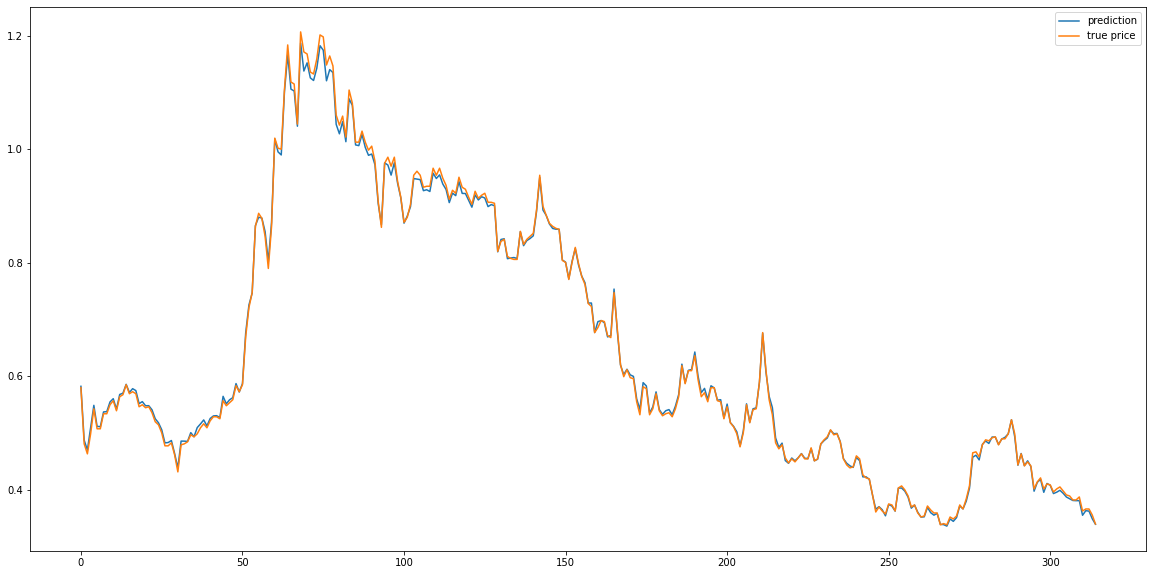

4.0428336374779884e-05


In [ ]:
# 아다 시각화
x1 = []
for i in range(ADA_prediction.shape[0]):
    x1.append(i)

plt.figure(figsize = (20,10)) 
plt.plot(x1,ADA_prediction,label = 'prediction')
plt.plot(x1, ADA_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE

ADA_MSE = mean_squared_error(ADA_prediction,ADA_y_test)
print(ADA_MSE)

In [ ]:
# 퀸텀 학습
QTUM_model = Sequential() 

QTUM_model.add(LSTM(units = 256,
            return_sequences = True,
            input_shape = (3,20),
            kernel_initializer=initializer,
            activation = 'tanh'))    

QTUM_model.add(LSTM(units = 256,
            kernel_initializer=initializer,
            return_sequences = True,
            activation = 'tanh'))

QTUM_model.add(LSTM(units = 128,
            kernel_initializer=initializer,
            activation = 'tanh'))

QTUM_model.add(Dense(units = 1))

QTUM_model.compile(optimizer = Adam(lr=0.001),
            loss = 'Huber')
QTUM_model.fit(QTUM_x_train,QTUM_y_train, epochs = 200, batch_size = 32, verbose = 0)
QTUM_prediction = QTUM_model.predict(QTUM_x_test)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


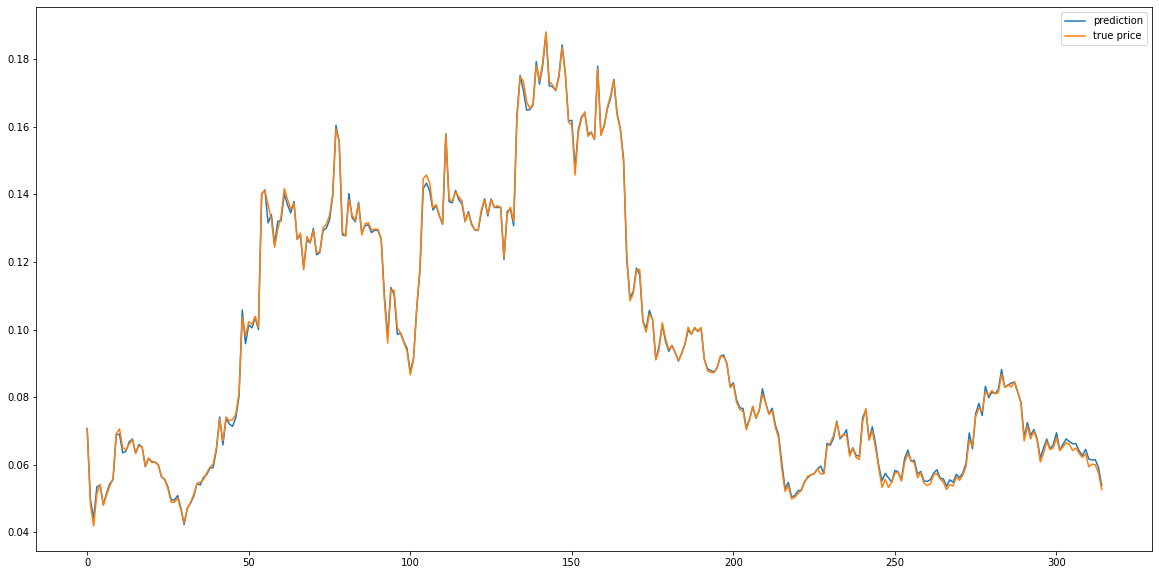

9.826006428567612e-07


In [ ]:
# 퀀텀 시각화
x1 = []
for i in range(QTUM_prediction.shape[0]):
    x1.append(i)

plt.figure(figsize = (20,10))
plt.plot(x1,QTUM_prediction,label = 'prediction')
plt.plot(x1, QTUM_y_test,label = 'true price')
plt.legend()
plt.show()

# MSE

QTUM_MSE = mean_squared_error(QTUM_prediction,QTUM_y_test)
print(QTUM_MSE)

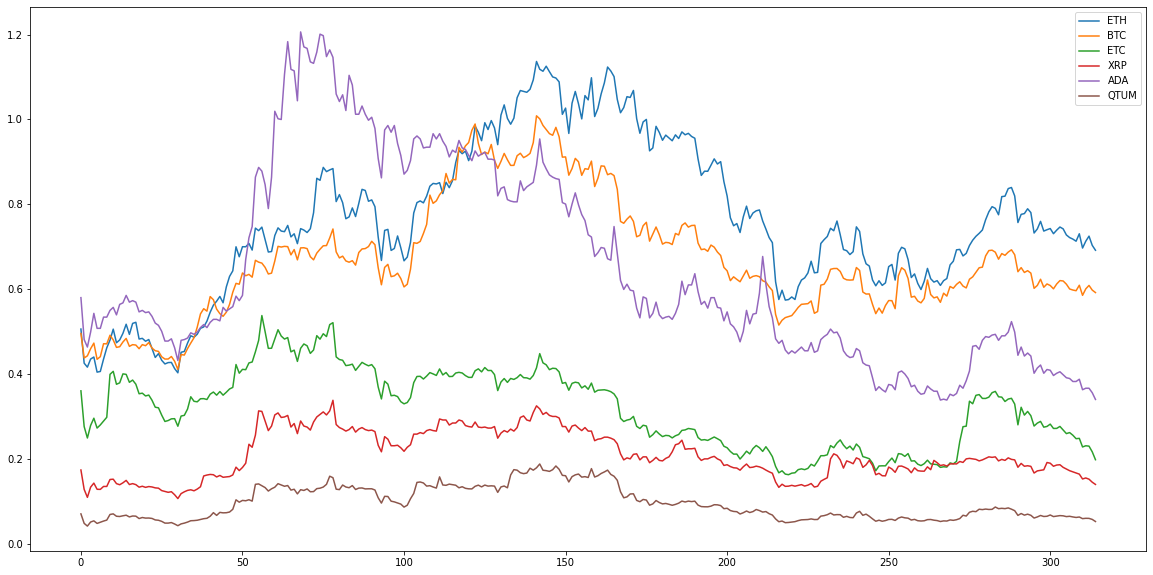

In [ ]:
x1 = []
for i in range(315):
    x1.append(i)
    
plt.figure(figsize = (20,10))    
plt.plot(x1, ETH_y_test,label = 'ETH')
plt.plot(x1, BTC_y_test,label = 'BTC')
plt.plot(x1, ETC_y_test,label = 'ETC')
plt.plot(x1, XRP_y_test,label = 'XRP')
plt.plot(x1, ADA_y_test,label = 'ADA')
plt.plot(x1, QTUM_y_test,label = 'QTUM')

plt.legend()
plt.show()

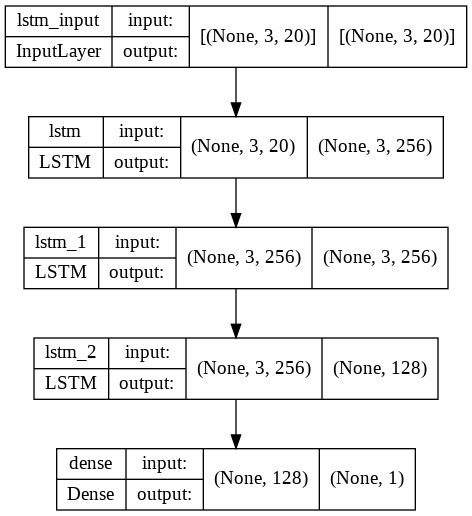

In [ ]:
# 모델 아키텍쳐
plot_model(ETH_model, show_shapes=True)

In [ ]:
ETH_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 256)            283648    
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,006,209
Trainable params: 1,006,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 저장
ETH_model.save('ETH_mdoel.h5')
BTC_model.save('BTC_mdoel.h5')
ETC_model.save('ETC_mdoel.h5')
XRP_model.save('XRP_mdoel.h5')
ADA_model.save('ADA_mdoel.h5')
QTUM_model.save('QTUM_mdoel.h5')

In [ ]:
# 위쪽까진 가격 예측, 이제부터 솔루션

SyntaxError: ignored

In [ ]:
# 모델 불러오기
ETH_model = load_model('ETH_model.h5')
BTC_model = load_model('BTC_model.h5')
ETC_model = load_model('ETC_model.h5')
XRP_model = load_model('XRP_model.h5')
ADA_model = load_model('ADA_model.h5')
QTUM_model = load_model('QTUM_model.h5')

In [ ]:
# 솔루션
# 가격 데이터 가져오기
df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",3)
df_ETH = df_ETH.drop("value",axis=1)

df_BTC = pyupbit.get_ohlcv("KRW-BTC","hour",3)
df_BTC= df_BTC.drop("value",axis=1)

df_ETC = pyupbit.get_ohlcv("KRW-ETC","hour",3)
df_ETC = df_ETC.drop("value",axis=1)

df_XRP = pyupbit.get_ohlcv("KRW-XRP","hour",3)
df_XRP = df_XRP.drop("value",axis=1)

df_ADA = pyupbit.get_ohlcv("KRW-ADA","hour",3)
df_ADA = df_ADA.drop("value",axis=1)

df_QTUM = pyupbit.get_ohlcv("KRW-QTUM","hour",3)
df_QTUM = df_QTUM.drop("value",axis=1)


In [ ]:
# 경제지표 데이터 가져오기
import requests
import json
from datetime import datetime
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from datetime import datetime
from pytz import timezone
import talib as ta

def getdata(search_text,st_date,end_date):
    headers={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36','X-Requested-With':'XMLHttpRequest',}
    data={'search_text':search_text,}
    result1=requests.post('https://www.investing.com/search/service/searchTopBar',data=data,headers=headers)
    data=result1.json()
    first_quote_result=data['quotes'][0]
    curr_id=first_quote_result['pairId'] 
    data={'curr_id':curr_id,'st_date':st_date,'end_date':end_date,'interval_sec':'Daily','action':'historical_data',}
    result2=requests.post('https://www.investing.com/instruments/HistoricalDataAjax',data=data,headers=headers)
    data=result2.text
    data=pd.read_html(data)
    hist_data=data[0]
    return pd.DataFrame(hist_data)

today=datetime.today().strftime('%Y-%m-%d')
now=datetime.strptime(today, "%Y-%m-%d").strftime('%m/%d/%Y')

Bitcoin=getdata('bitcoin','01/01/2018',now)
TenYear=getdata('united states 10-Year','01/01/2018',now)
OVX=getdata('ovx','01/01/2018',now)
VIX=getdata('vix','01/01/2018',now)

lr=LinearRegression()
imp=IterativeImputer(estimator=lr, tol=1e-10, max_iter=30, verbose=2, imputation_order='roman')

Bitcoin=Bitcoin.drop(Bitcoin.columns[1:],axis=1)
TenYear=TenYear.drop(TenYear.columns[5],axis=1)
OVX=OVX.drop(OVX.columns[5:7],axis=1)
VIX=VIX.drop(VIX.columns[5:7],axis=1)
TenYear.columns=['Date','YOpen','YHigh','YLow','YClose']
OVX.columns=['Date','ovxOpen','ovxHigh','ovxYLow','ovxClose']
VIX.columns=['Date','vixOpen','vixHigh','vixLow','vixClose']

data=pd.merge(left=Bitcoin, right=TenYear, how='outer',on="Date")
data=pd.merge(left=data, right=OVX, how='outer',on="Date")
data=pd.merge(left=data, right=VIX, how='outer',on="Date")
data=data.drop(data.columns[0],axis=1)

data=imp.fit_transform(data)

Otherdata = pd.DataFrame(data, columns=['YOpen','YHigh','YLow','YClose','ovxOpen','ovxHigh','ovxLow','ovxClose','vixOpen','vixHigh','vixLow','vixClose'])
Otherdata=pd.concat([Bitcoin, Otherdata], axis = 1)
Otherdata['Date']=pd.to_datetime(Otherdata['Date'])
Otherdata=Otherdata.sort_values(by=['Date'])
Otherdata=Otherdata.drop(Otherdata.columns[0],axis=1)
Otherdata.reset_index(drop=True, inplace = True)

ModuleNotFoundError: ignored

In [ ]:
 url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

In [ ]:
 # 기술지표 데이터 가져오기

def getPrice(search,n,finish_date):
    df=pyupbit.get_ohlcv(search,'hour',p,to=finish_date)
    df=df.drop("value",axis=1)
    return pd.DataFrame(df)

def getADX(data):
    adx=ta.ADX(data['high'],data['low'],data['close'],timeperiod=14)
    adx=adx[50:]
    return pd.DataFrame(adx)

def getMA50(data):
    MA50=ta.MA(data['close'],timeperiod=50, matype=0)
    MA50=MA50[50:]
    return pd.DataFrame(MA50)

def getMACD_signal(data):
    MACD,MACD_signal,MACD_hist=ta.MACD(data['close'],fastperiod=12, slowperiod=26, signalperiod=9)
    MACD_signal=MACD_signal[50:]
    return pd.DataFrame(MACD_signal)

today=datetime.now().date()
start=datetime.strptime("20171111", "%Y%m%d").date()
p=(today-start).days

BTC=getPrice('KRW-BTC',p,'today')
ETH=getPrice('KRW-ETH',p,'today')
ETC=getPrice('KRW-ETC',p,'today')
ADA=getPrice('KRW-ADA',p,'today')
QTUM=getPrice('KRW-QTUM',p,'today')
XRP=getPrice('KRW-XRP',p,'today')

ADX_BTC=getADX(BTC)
ADX_ETH=getADX(ETH)
ADX_ETC=getADX(ETC)
ADX_ADA=getADX(ADA)
ADX_QTUM=getADX(QTUM)
ADX_XRP=getADX(XRP)

MA50_BTC=getMA50(BTC)
MA50_ETH=getMA50(ETH)
MA50_ETC=getMA50(ETC)
MA50_ADA=getMA50(ADA)
MA50_QTUM=getMA50(QTUM)
MA50_XRP=getMA50(XRP)


MACD_signal_BTC=getMACD_signal(BTC)
MACD_signal_ETH=getMACD_signal(ETH)
MACD_signal_ETC=getMACD_signal(ETC)
MACD_signal_ADA=getMACD_signal(ADA)
MACD_signal_QTUM=getMACD_signal(QTUM)
MACD_signal_XRP=getMACD_signal(XRP)

Fin_BTC=pd.concat([ADX_BTC,MA50_BTC,MACD_signal_BTC],axis=1)
Fin_BTC.columns=['ADX_BTC','MA50_BTC','MACD_signal_BTC']
Fin_ETH=pd.concat([ADX_ETH,MA50_ETH,MACD_signal_ETH],axis=1)
Fin_ETH.columns=['ADX_ETH','MA50_ETH','MACD_signal_ETH']
Fin_ETC=pd.concat([ADX_ETC,MA50_ETC,MACD_signal_ETC],axis=1)
Fin_ETC.columns=['ADX_ETC','MA50_ETC','MACD_signal_ETC']
Fin_ADA=pd.concat([ADX_ADA,MA50_ADA,MACD_signal_ADA],axis=1)
Fin_ADA.columns=['ADX_ADA','MA50_ADA','MACD_signal_ADA']
Fin_QTUM=pd.concat([ADX_QTUM,MA50_QTUM,MACD_signal_QTUM],axis=1)
Fin_QTUM.columns=['ADX_QTUM','MA50_QTUM','MACD_signal_QTUM']
Fin_XRP=pd.concat([ADX_XRP,MA50_XRP,MACD_signal_XRP],axis=1)
Fin_XRP.columns=['ADX_XRP','MA50_XRP','MACD_signal_XRP']

Fin_Last=pd.concat([Fin_BTC,Fin_ETH,Fin_ETC,Fin_ADA,Fin_QTUM,Fin_XRP],axis=1)
Fin_Last.reset_index(drop=True, inplace = True)



In [ ]:
# 데이터 합치기

Data=pd.concat([Otherdata,Fin_Last],axis=1)
data=Data[-3:]
print(Data.isnull().sum())
print(data)

data.set_index(df_ETH.index, inplace = True)

df_ETH = pd.concat([df_ETH, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,15,16,17]]], axis=1)
df_BTC = pd.concat([df_BTC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]], axis=1)
df_ETC = pd.concat([df_ETC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,18,19,20]]], axis=1)
df_XRP = pd.concat([df_XRP, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,27,28,29]]], axis=1)
df_ADA = pd.concat([df_ADA, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,21,22,23]]], axis=1)
df_QTUM = pd.concat([df_QTUM, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,24,25,26]]], axis=1)

In [ ]:
df_ETH.info()

In [ ]:
df_ETH = df_ETH.to_numpy()
df_BTC = df_BTC.to_numpy()
df_ETC = df_ETC.to_numpy()
df_XRP = df_XRP.to_numpy()
df_ADA = df_ADA.to_numpy()
df_QTUM = df_QTUM.to_numpy()

In [ ]:
# min-max 정규화
df_ETH = sc_ETH.transform(df_ETH)
df_BTC = sc_BTC.transform(df_BTC)
df_ETC = sc_ETC.transform(df_ETC)
df_XRP = sc_XRP.transform(df_XRP)
df_ADA = sc_ADA.transform(df_ADA)
df_QTUM = sc_QTUM.transform(df_QTUM)

In [ ]:
df_ETH = df_ETH.reshape(1,3,20)
df_BTC = df_BTC.reshape(1,3,20)
df_ETC = df_ETC.reshape(1,3,20)
df_XRP = df_XRP.reshape(1,3,20)
df_ADA = df_ADA.reshape(1,3,20)
df_QTUM = df_QTUM.reshape(1,3,20)



ETH_prediction = ETH_model.predict(df_ETH)
BTC_prediction = BTC_model.predict(df_BTC)
ETC_prediction = ETC_model.predict(df_ETC)
XRP_prediction = XRP_model.predict(df_XRP)
ADA_prediction = ADA_model.predict(df_ADA)
QTUM_prediction = QTUM_model.predict(df_QTUM)


In [ ]:
# 현재가
ETH_current = pyupbit.get_current_price("KRW-ETH")
BTC_current = pyupbit.get_current_price("KRW-BTC")
ETC_current = pyupbit.get_current_price("KRW-ETC")
XRP_current = pyupbit.get_current_price("KRW-XRP")
ADA_current = pyupbit.get_current_price("KRW-ADA")
QTUM_current = pyupbit.get_current_price("KRW-QTUM")

In [ ]:
# 현재가 정규화

a = np.zeros((1,20))
b1 = a + ETH_current
ETH_current = sc_ETH.transform(b1)
ETH_current = ETH_current[-1,3]


a = np.zeros((1,20))
b1 = a + BTC_current
BTC_current = sc_BTC.transform(b1)
BTC_current = BTC_current[-1,3]

a = np.zeros((1,20))
b1 = a + ETC_current
ETC_current = sc_ETC.transform(b1)
ETC_current = ETC_current[-1,3]

a = np.zeros((1,20))
b1 = a + XRP_current
XRP_current = sc_XRP.transform(b1)
XRP_current = XRP_current[-1,3]

a = np.zeros((1,20))
b1 = a + ADA_current
ADA_current = sc_ADA.transform(b1)
ADA_current = ADA_current[-1,3]
                               

a = np.zeros((1,20))
b1 = a + QTUM_current
QTUM_current = sc_QTUM.transform(b1)
QTUM_current = QTUM_current[-1,3]


In [ ]:
ETH_current

In [ ]:
ETH_rate = float((ETH_prediction - ETH_current)/ETH_current)
BTC_rate = float((BTC_prediction - BTC_current)/BTC_current)
ETC_rate = float((ETC_prediction - ETC_current)/ETC_current)
XRP_rate = float((XRP_prediction - XRP_current)/XRP_current)
ADA_rate = float((ADA_prediction - ADA_current)/ADA_current)
QTUM_rate = float((QTUM_prediction - QTUM_current)/QTUM_current)

coin = ["KRW-ETH","KRW-BTC","KRW-ETC","KRW-XRP","KRW-ADA","KRW-QTUM"]

rate_list = [ETH_rate,BTC_rate,ETC_rate,XRP_rate,ADA_rate,QTUM_rate]
plus_index = []
plus_rate = []
plus_coin =[]

for i in range(6):
    if rate_list[i] > 0:
        plus_index.append(i)
        plus_rate.append(rate_list[i])

for i in plus_index:
    plus_coin.append(coin[i])

warning = "솔루션 제공 불가"


In [ ]:
print(rate_list)
print(plus_index)
print(plus_rate)
print(plus_coin)

In [ ]:
# 솔루션 high risk

def highrisk(rate_list,coin):
    a = np.max(rate_list)
    
    # 제일 높은 rate가 양수라면
    if a > 0:
        return coin[rate_list.index(a)]
    else:
        return warning

In [ ]:
highrisk(rate_list,coin)

In [ ]:
def lowrisk(plus_rate,plus_coin):
    # rate들 중 양수가 하나라도 있다면
    if plus_rate != []:
        b = []           
        for i in range(len(plus_rate)):            
            a = plus_rate[i]/np.sum(plus_rate)
            b.append([plus_coin[i],a])
        return b
    else:
        return warning

In [ ]:
lowrisk(plus_rate,plus_coin)

In [ ]:
plus_rate

In [ ]:
# 추가하면 좋을 것 같은 기능들
# 1. 예상 이득 출력
# 2. 오전 9시 직전에 돌리는 것이 가장 정확하다는 사실을 고지


In [ ]:
# 백테스팅 8월

In [ ]:
# 학습에 쓰일 값
df_ETH = pyupbit.get_ohlcv("KRW-ETH","hour",34, to = '20220901')
df_ETH = df_ETH.drop("value",axis=1)

df_BTC = pyupbit.get_ohlcv("KRW-BTC","hour",34, to = '20220901')
df_BTC= df_BTC.drop("value",axis=1)

df_ETC = pyupbit.get_ohlcv("KRW-ETC","hour",34, to = '20220901')
df_ETC = df_ETC.drop("value",axis=1)

df_XRP = pyupbit.get_ohlcv("KRW-XRP","hour",34, to = '20220901')
df_XRP = df_XRP.drop("value",axis=1)

df_ADA = pyupbit.get_ohlcv("KRW-ADA","hour",34, to = '20220901')
df_ADA = df_ADA.drop("value",axis=1)

df_QTUM = pyupbit.get_ohlcv("KRW-QTUM","hour",34, to = '20220901')
df_QTUM = df_QTUM.drop("value",axis=1)

In [ ]:
data = pd.read_csv('Data(8).csv')

In [ ]:
data_plus = data.iloc[0:1,:]

In [ ]:
data = pd.concat([data_plus,data],axis=0)

In [ ]:
data.set_index(df_ETH.index, inplace = True)

df_ETH = pd.concat([df_ETH, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,15,16,17]]], axis=1)
df_BTC = pd.concat([df_BTC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]]], axis=1)
df_ETC = pd.concat([df_ETC, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,18,19,20]]], axis=1)
df_XRP = pd.concat([df_XRP, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,27,28,29]]], axis=1)
df_ADA = pd.concat([df_ADA, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,21,22,23]]], axis=1)
df_QTUM = pd.concat([df_QTUM, data.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,24,25,26]]], axis=1)

In [ ]:
ETH = sc_ETH.transform(df_ETH)
BTC = sc_BTC.transform(df_BTC)
ETC = sc_ETC.transform(df_ETC)
XRP = sc_XRP.transform(df_XRP)
ADA = sc_ADA.transform(df_ADA)
QTUM = sc_QTUM.transform(df_QTUM)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted wi

In [ ]:
ETH = pd.DataFrame(ETH)
BTC = pd.DataFrame(BTC)
ETC = pd.DataFrame(ETC)
XRP = pd.DataFrame(XRP)
ADA = pd.DataFrame(ADA)
QTUM = pd.DataFrame(QTUM)

In [ ]:
ETH_train = ETH.iloc[0:33]
ETH_current = ETH.iloc[2:33][3]
ETH_future = ETH.iloc[3:34][3]

BTC_train = BTC.iloc[0:33]
BTC_current = BTC.iloc[2:33][3]
BTC_future = BTC.iloc[3:34][3]

ETC_train = ETC.iloc[0:33]
ETC_current = ETC.iloc[2:33][3]
ETC_future = ETC.iloc[3:34][3]

XRP_train = XRP.iloc[0:33]
XRP_current = XRP.iloc[2:33][3]
XRP_future = XRP.iloc[3:34][3]

ADA_train = ADA.iloc[0:33]
ADA_current = ADA.iloc[2:33][3]
ADA_future = ADA.iloc[3:34][3]

QTUM_train = QTUM.iloc[0:33]
QTUM_current = QTUM.iloc[2:33][3]
QTUM_future = QTUM.iloc[3:34][3]

In [ ]:
ETH_train = np.array(ETH_train)
BTC_train = np.array(BTC_train)
ETC_train = np.array(ETC_train)
XRP_train = np.array(XRP_train)
ADA_train = np.array(ADA_train)
QTUM_train = np.array(QTUM_train)

ETH_current = np.array(ETH_current)
BTC_current = np.array(BTC_current)
ETC_current = np.array(ETC_current)
XRP_current = np.array(XRP_current)
ADA_current = np.array(ADA_current)
QTUM_current = np.array(QTUM_current)

ETH_future = np.array(ETH_future)
BTC_future = np.array(BTC_future)
ETC_future = np.array(ETC_future)
XRP_future = np.array(XRP_future)
ADA_future = np.array(ADA_future)
QTUM_future = np.array(QTUM_future)

In [ ]:
def inputsize(df_train):
    x_train = []    
    
    for i in range(3,len(df_train)+1):
        x_train.append(df_train[i-3:i,:])        
    
    x_train = np.array(x_train)
    return x_train

ETH_x = inputsize(ETH_train)
BTC_x = inputsize(BTC_train)
ETC_x = inputsize(ETC_train)
XRP_x = inputsize(XRP_train)
ADA_x = inputsize(ADA_train)
QTUM_x = inputsize(QTUM_train)

In [ ]:
# 예측값
ETH_prediction = ETH_model.predict(ETH_x)
BTC_prediction = BTC_model.predict(BTC_x)
ETC_prediction = ETC_model.predict(ETC_x)
XRP_prediction = XRP_model.predict(XRP_x)
ADA_prediction = ADA_model.predict(ADA_x)
QTUM_prediction = QTUM_model.predict(QTUM_x)

In [ ]:
ETH_current = ETH_current.reshape(31,1)
ETH_future = ETH_future.reshape(31,1)

BTC_current = BTC_current.reshape(31,1)
BTC_future = BTC_future.reshape(31,1)

ETC_current = ETC_current.reshape(31,1)
ETC_future = ETC_future.reshape(31,1)

XRP_current = XRP_current.reshape(31,1)
XRP_future = XRP_future.reshape(31,1)

ADA_current = ADA_current.reshape(31,1)
ADA_future = ADA_future.reshape(31,1)

QTUM_current = QTUM_current.reshape(31,1)
QTUM_future = QTUM_future.reshape(31,1)

In [ ]:
# 현재값과 예측값으로 구한 rate
ETH_rate = (ETH_prediction - ETH_current)/ETH_current
BTC_rate = (BTC_prediction - BTC_current)/BTC_current
ETC_rate = (ETC_prediction - ETC_current)/ETC_current
XRP_rate = (XRP_prediction - XRP_current)/XRP_current
ADA_rate = (ADA_prediction - ADA_current)/ADA_current
QTUM_rate = (QTUM_prediction - QTUM_current)/QTUM_current

# 실제 손익 rate

ETH_pl = (ETH_future - ETH_current)/ETH_current
BTC_pl = (BTC_future - BTC_current)/BTC_current
ETC_pl = (ETC_future - ETC_current)/ETC_current
XRP_pl = (XRP_future - XRP_current)/XRP_current
ADA_pl = (ADA_future - ADA_current)/ADA_current
QTUM_pl = (QTUM_future - QTUM_current)/QTUM_current

In [ ]:
print(ETH_rate)
print(BTC_rate)
print(ETC_rate)
print(XRP_rate)
print(ADA_rate)
print(QTUM_rate)

[[0.02450015]
 [0.02395979]
 [0.01904503]
 [0.01891326]
 [0.01897546]
 [0.02241587]
 [0.01827066]
 [0.0174526 ]
 [0.02325193]
 [0.01943777]
 [0.01900626]
 [0.02312888]
 [0.01817068]
 [0.0186911 ]
 [0.01949836]
 [0.02292345]
 [0.02376595]
 [0.02433301]
 [0.02362741]
 [0.02234781]
 [0.02289128]
 [0.0247796 ]
 [0.01300861]
 [0.01361295]
 [0.01348294]
 [0.01838935]
 [0.01956642]
 [0.01881553]
 [0.02335035]
 [0.02076204]
 [0.01750626]]
[[ 0.00627021]
 [ 0.00338658]
 [ 0.00109532]
 [ 0.0039963 ]
 [ 0.00234946]
 [ 0.00174932]
 [ 0.00246524]
 [ 0.00057323]
 [ 0.00402684]
 [-0.00014101]
 [ 0.00055027]
 [ 0.0099349 ]
 [ 0.00021748]
 [ 0.005551  ]
 [ 0.00370257]
 [ 0.00801251]
 [ 0.00337227]
 [ 0.00713948]
 [ 0.00347583]
 [ 0.00957257]
 [ 0.00010898]
 [ 0.00571698]
 [-0.00374641]
 [-0.00269906]
 [ 0.00156958]
 [ 0.00086039]
 [ 0.00228084]
 [ 0.00159648]
 [ 0.00376911]
 [-0.00169663]
 [ 0.00377702]]
[[ 0.0226273 ]
 [ 0.0161184 ]
 [ 0.00499886]
 [ 0.0114566 ]
 [ 0.00687345]
 [ 0.00639059]
 [ 0.0041

In [ ]:
print(ETH_pl)
print(BTC_pl)
print(ETC_pl)
print(XRP_pl)
print(ADA_pl)
print(QTUM_pl)

[[-0.02263564]
 [ 0.00771996]
 [-0.00239401]
 [-0.01295865]
 [ 0.06904768]
 [-0.02092288]
 [ 0.00325196]
 [ 0.04352759]
 [-0.03017461]
 [ 0.07549587]
 [ 0.02212248]
 [ 0.04162244]
 [ 0.01878084]
 [-0.0196113 ]
 [-0.01320238]
 [-0.01500071]
 [-0.01728715]
 [ 0.01968545]
 [-0.13020887]
 [-0.00991712]
 [ 0.01192435]
 [ 0.00235677]
 [ 0.0197503 ]
 [-0.0036891 ]
 [ 0.02082803]
 [-0.09702795]
 [-0.01154879]
 [-0.04241701]
 [ 0.07824726]
 [-0.01180783]
 [ 0.01642976]]
[[ 0.00368568]
 [-0.00356199]
 [-0.00169523]
 [-0.01450773]
 [ 0.01693138]
 [-0.00858258]
 [ 0.00561025]
 [ 0.02859676]
 [-0.01659483]
 [ 0.02140405]
 [ 0.00668717]
 [ 0.02124258]
 [ 0.00674806]
 [-0.00062191]
 [-0.00342264]
 [-0.0125928 ]
 [-0.01879633]
 [ 0.0061945 ]
 [-0.10825238]
 [ 0.02641765]
 [ 0.00462657]
 [-0.00770124]
 [ 0.001833  ]
 [-0.00790252]
 [ 0.0076908 ]
 [-0.0518282 ]
 [-0.00944559]
 [-0.026534  ]
 [ 0.02951448]
 [-0.01977413]
 [ 0.00911585]]
[[-0.03818616]
 [ 0.06049864]
 [-0.01002786]
 [-0.04074282]
 [ 0.093